## Final Project
### Effect of Stellar Mass on Planetary Multiplicity

CS-GY 6053 – Foundations of Data Science
<br><br> Claire Hattaway, Chiranjeev Kumar, Hyun Sang Ryu, Raunak Ahmed
***

**Question/Estimand**
<ul>How does stellar mass influence the number of planets that a star hosts in its solar system (planetary multiplicity)?</ul>

**Data Description**
<ul>Data Source: https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=STELLARHOSTS</ul>
<ul>Description: The dataset is hosted by NASA’s Exoplanet Archive with rows representing stars that are solar hosts in a solar system. Within the dataset, there are columns present that cover the necessary information needed to account for our treatment, outcome and confound variables. Column name descriptions and a sample of the data is provided below.
<ul><li>sy_name: Name of solar system</li>
<li>hostname: Name of host star in the system</li>
<li>sy_pnum: Number of planets in the system</li>
<li>st_teff: Stellar effective temperature (Kelvin)</li>
<li>st_mass: Stellar mass</li>
<li>st_met: Stellar metallicity</li></ul></ul>

In [1]:
import pandas as pd

df = pd.read_csv('data.csv')
print(df.head())

  sy_name   hostname  sy_pnum Stellar Parameter Reference  st_teff  st_mass  \
0  14 Her     14 Her        2                       TICv8   5280.0     0.91   
1  16 Cyg  HIP 96895        1                       TICv8   5778.0     1.04   
2  16 Cyg   16 Cyg B        1                       TICv8   5747.0     1.03   
3  47 UMa     47 UMa        3                       TICv8   5872.0     1.06   
4  51 Peg     51 Peg        1                       TICv8   5758.0     1.03   

   st_met st_metratio  
0    0.40       [M/H]  
1    0.09       [M/H]  
2    0.06       [M/H]  
3    0.04       [M/H]  
4    0.18       [M/H]  


**Causal Model**
<br>Variables:
<ul><li>Treatment (T): Stellar mass- calculated mass of a star</li>
<li>Outcome (Y): Number of planets- the number of planets hosted by a solar system</li>
<li>Confound 1 (E): Stellar effective temperature- measure of star’s surface temperature, using luminosity and radius</li>
<li>Confound 2 (M): Stellar metallicity- abundance of elements in a star that is heavier than helium and hydrogen</li></ul>

![DAG](DAG.png)

**How do the variables interact with one another?**
<ul><li>Stellar metallicity: Higher metallicity ratios lead stars to have cooler temperatures and lose more mass over time than stars with lower metallicity. Additionally, higher metallicty ratios increase the amount of solid material available for planet formation, tending to yield a greater number of planets in a system.</li>
<li>Stellar mass: An increase in stellar mass increases the star's effective temperature, due to the increased gravitational pressure. Planetary multiplicity also decreases with increased stellar mass.</li>
<li> Stellar effective temperature: Similar to stellar mass, increasing stellar effect temperatures tends to decrease the number of planets in the system.</li></ul>

References:
https://burro.case.edu/Academics/Astr222/Galaxy/Structure/metals.html#:~:text=Line%20blanketing:%20lots%20of%20metals,them%20cooler%20(redder)%20temperatures.
<br>https://public.nrao.edu/ask/does-metallicity-affect-the-evolution-of-a-star/#:~:text=The%20abundance%20of%20elements%20heavier,supernova%20and%20a%20black%20hole.
<br>https://iopscience.iop.org/article/10.3847/1538-4357/ab0205/pdf#:~:text=The%20whole%20sample%20is%20unevenly,planets%20to%20compute%20the%20tracers.&text=metallicities%2C%20but%20these%20systems%20were,tonically%20increasing%20with%20stellar%20metallicity.&text=reflects%20the%20final%20outcome%20of,directly%20the%20planet%20formation%20efficiency.
<br>https://iopscience.iop.org/article/10.3847/1538-3881/ab7373/pdf#:~:text=The%20Kepler%20mission%20has%20discovered,%CE%94AIC%EF%82%A0%E2%88%BC%EF%82%A05




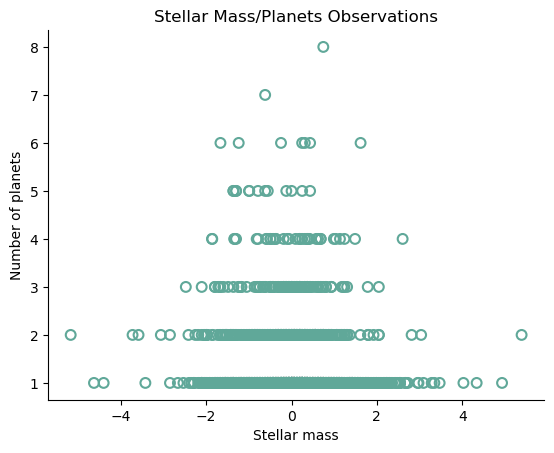

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

def standardize(series):
    return (series - series.mean()) / series.std()

mass_std = standardize(df.st_mass)
met_std = standardize(df.st_met)
teff_std = standardize(df.st_teff)

# Initial plot of data
sns.scatterplot(x=mass_std, y=df.sy_pnum, edgecolor='#60a899', facecolor='none', s=50, linewidth=1.5)
plt.xlabel("Stellar mass")
plt.ylabel("Number of planets")
plt.title('Stellar Mass/Planets Observations')
sns.despine()

**Statistical Model**
<br>Assumed Distribution for Outcome Variable
<br>$Y_i \sim Poisson(\lambda_i)$
<br> Given that planetary multiplicity is a countable feature, we have chosen a Poisson distribution to capture the low probability of a very high number of planets in a system.

Model Structures
<br>No collider: $log(\lambda_i) = \alpha + \beta T_i + \beta M_i$
<br>Collider: $log(\lambda_i) = \alpha + \beta T_i + \beta M_i + \beta E_i$
<br>For our project, we will be using two models to estimate the number of planets in a given system. Since stellar effect temperature is a collider in our causal model, we will examine two models: one excluding temperature as a predictor and one including temperature.

Priors
<br>$\alpha \sim Normal(0.4, 0.6)$
<br>$\beta \sim Normal(0, 0.1)$
<br>Prior values were chosen using a combination of outside sources and prior predictive simulations. Based on resources, we were able to estimate that the average number of planets for a given solar system is between 1 and 2. Given this estimation, we chose to use 1.5 as our intercept prior, using the log transformation for the Poisson link function to yield our intercept mean of 0.4. Additionally, we will be using standardized confounds, so our slope prior is set at a mean value of 0. The standard deviations for $\alpha$ and $\beta$ values were adjusted after performing the prior predictive simulation. Prior simulations are included below for reference.

/opt/conda/envs/fnds/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


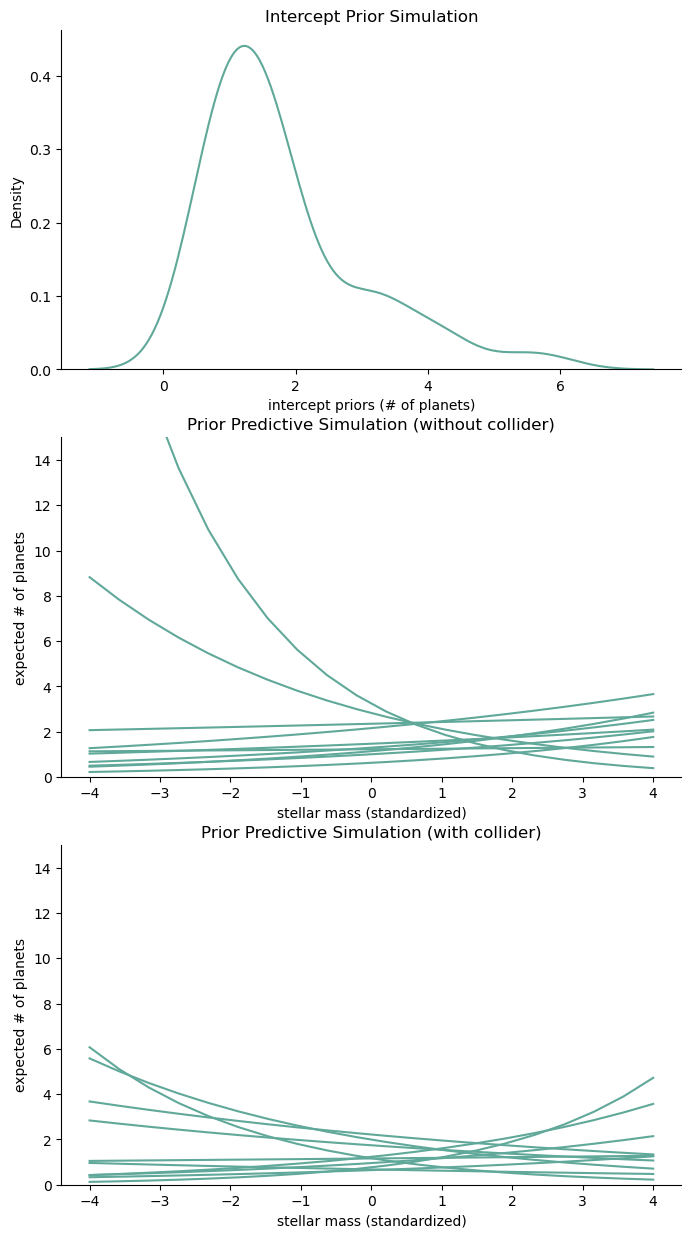

In [73]:
import pymc as py
from scipy import stats
import numpy as np

_, ax = plt.subplots(3, 1, figsize=(8,15))

# Intercept predictive simulation
alpha_io = stats.norm.rvs(0.4, 0.6, size = 100)
lambda_io = np.exp(alpha_io)

sns.kdeplot(lambda_io, color="#60a899", ax=ax[0])
ax[0].set_xlabel("intercept priors (# of planets)")
ax[0].set_ylim(bottom=-2e-13)
ax[0].set_title("Intercept Prior Simulation")

# Prior predictive simulation without collider
NUM_LINES = 10
t_seq = np.linspace(-4, 4, 20)
m_seq = np.linspace(-5, 2, 20)

alpha = stats.norm.rvs(0.4, 0.6, size=NUM_LINES)
beta = stats.norm.rvs(0, 0.2, size=NUM_LINES)

for i in range(NUM_LINES):
    lambdas = np.exp(alpha[i] + beta[i] * t_seq + beta[i] * m_seq)
    ax[1].plot(t_seq, lambdas, color="#60a899")
    
ax[1].set_ylim((0,15))
ax[1].set_ylabel("expected # of planets")
ax[1].set_xlabel("stellar mass (standardized)")
ax[1].set_title("Prior Predictive Simulation (without collider)")

# Collider as a predictor prior predictive simulation
NUM_LINES = 10
t_seq = np.linspace(-4, 4, 20)
m_seq = np.linspace(-5, 2, 20)
e_seq = np.linspace(-4, 4, 20)

alpha = stats.norm.rvs(0.4, 0.6, size=NUM_LINES)
beta = stats.norm.rvs(0, 0.1, size=NUM_LINES)

for i in range(NUM_LINES):
    lambdas = np.exp(alpha[i] + beta[i] * t_seq + beta[i] * m_seq + beta[i] * e_seq)
    ax[2].plot(t_seq, lambdas, color="#60a899")
    
ax[2].set_ylim((0,15))
ax[2].set_ylabel("expected # of planets")
ax[2].set_xlabel("stellar mass (standardized)")
ax[2].set_title("Prior Predictive Simulation (with collider)")
sns.despine();